# Vizualization

## Data Preparation

In [ ]:
import pandas as pd

In [ ]:
labelled_data = pd.read_csv('resources/postcodes_labelled.csv')
labelled_data.head()

### clean typical day data

In [ ]:
typical_data = pd.read_csv('resources/typical_day.csv')
typical_data.head()

In [ ]:
typical_data.drop(columns=['dateTime','qualifier'],inplace=True)
typical_data

In [ ]:
typical_data[['parameter','unitName']].value_counts()

###### For level we only want mASD and mAOD

In [ ]:
m_index = typical_data[(typical_data['parameter']=='level')&(typical_data['unitName']=='m')].index

In [ ]:
typical_data = typical_data.drop(index=m_index)

In [ ]:
mm_index = typical_data[(typical_data['parameter']=='level')&(typical_data['unitName']=='mm')].index

In [ ]:
typical_data = typical_data.drop(index=mm_index)

In [ ]:
typical_data[['parameter','unitName']].value_counts()

In [ ]:
typical_data.isnull().sum()

In [ ]:
typical_data.dropna(subset=['value'], inplace=True)

In [ ]:
typical_data.isnull().sum()

In [ ]:
typical_data.head()

In [ ]:
typical_data['value'] = pd.to_numeric(typical_data['value'], errors='coerce')

#### Now we want to group our data according to 'stationReference' and 'unitName' and obtain the max, min and mean values.

In [ ]:
typ_aggregated_df = typical_data.groupby(['stationReference', 'unitName'])['value'].agg(['max', 'min', 'mean']).reset_index()
typ_aggregated_df#[typ_aggregated_df['stationReference'] == 'E2900']

In [ ]:
typ_aggregated_df = typ_aggregated_df.rename(columns={'max': 'max_typ', 'min': 'min_typ', 'mean': 'mean_typ'})


In [ ]:
typ_aggregated_df

## clean wet day data

### We're going to follow the same steps as for the typical day

In [ ]:
wet_data = pd.read_csv('resources/wet_day.csv')
wet_data.head()

In [ ]:
wet_data.drop(columns=['dateTime','qualifier'],inplace=True)

In [ ]:
wet_data.isnull().sum()

In [ ]:
wet_data.dropna(subset=['value'], inplace=True)

In [ ]:
wet_data.isnull().sum()

In [ ]:
wet_data[['parameter','unitName']].value_counts()

In [ ]:
m2_index = wet_data[(wet_data['parameter']=='level')&(wet_data['unitName']=='m')].index

In [ ]:
wet_data = wet_data.drop(index=m2_index)

In [ ]:
wet_data[['parameter','unitName']].value_counts()

In [ ]:
wet_data['value'] = pd.to_numeric(wet_data['value'], errors='coerce')


In [ ]:
wet_aggregated_df = wet_data.groupby(['stationReference', 'unitName'])['value'].agg(['max', 'min', 'mean']).reset_index()
wet_aggregated_df

In [ ]:
wet_aggregated_df = wet_aggregated_df.rename(columns={'max': 'max_wet', 'min': 'min_wet', 'mean': 'mean_wet'})


In [ ]:
wet_aggregated_df

In [ ]:
wet_aggregated_df.stationReference.value_counts()

## merge wet and typical data around ['stationReference', 'unitName']

In [ ]:
merged_df1 = pd.merge(typ_aggregated_df, wet_aggregated_df, on=['stationReference', 'unitName'], how='inner')
merged_df1

## We now want to find the location based on 'stationReference', so we're going to use station_data

In [ ]:
station_data = pd.read_csv('resources/stations.csv')
station_data.head()

In [ ]:
station_data.isnull().sum()

In [ ]:
station_data = station_data.drop(columns=['stationName', 'maxOnRecord', 'minOnRecord', 'typicalRangeHigh', 'typicalRangeLow'])
station_data

## We merge around 'stationReference'

In [ ]:
merged_df2 = pd.merge(merged_df1, station_data, on=['stationReference'], how='inner')
merged_df2.latitude.isnull().sum()

### We now have access to the location of our data  

In [ ]:
import geo

In [ ]:
latitude = merged_df2['latitude'].values

In [ ]:
longitude = merged_df2['longitude'].values

In [ ]:
easting, northing = geo.get_easting_northing_from_gps_lat_long(latitude, longitude)

##### We're trying to obtain easting and northing from lat and long because later we want to match them with labelled data

In [ ]:
merged_df2['easting'] = easting

In [ ]:
merged_df2['northing'] = northing
merged_df2

In [ ]:
labelled_data

In [ ]:
merged_df2.dropna(subset=['latitude'], inplace=True)


In [ ]:
merged_df2

#### We're now going to try and match our merged_df2 lines with the labelled_data lines. To do this, the merge_nearest_neighbors() function will go through each merged_df2 line and use (eastings, northings) to find the closest pair (eastings, northings) present in labelled_data 

In [ ]:
from sklearn.neighbors import NearestNeighbors

def merge_nearest_neighbors(df_train, df_other):
    knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    knn.fit(df_train[['easting', 'northing']])
    
    distances, indices = knn.kneighbors(df_other[['easting', 'northing']])
    print(distances.max())

    
    columns = ['stationReference', 'unitName', 'max_typ', 'min_typ', 'mean_typ', 'max_wet', 'min_wet', 'mean_wet']
    

    df_other[columns] = df_train[columns].iloc[indices[:, 0]].values
 
    return df_other



result_df = merge_nearest_neighbors(merged_df2, labelled_data)
result_df

### We can see that when we look for the nearest neighbours, the maximum distance is 23215.9132468383 m (23km), which is acceptable given that we are working on an entire country

### We're going to encode soilType, maybe we'll use it later (the classification of these soil types by increasing order of severity of flood risk was found thanks to chatgpt)

In [ ]:
result_df.soilType.value_counts().index

In [ ]:
soil_type_mapping = {
    'Luvisols': 1,
    'Cambisols': 2,
    'Arenosols': 3,
    'Leptosols': 4,
    'Podsols': 5,
    'Planosols': 6,
    'Stagnosols': 7,
    'Gleysols': 8,
    'Histosols': 9,
    'Unsurveyed/Urban': 10
}

result_df['soil_type_encoded'] = result_df['soilType'].map(soil_type_mapping)


In [ ]:
result_df.soilType.isna().sum()

In [ ]:
result_df = result_df.drop(columns = 'soilType') 

In [ ]:
result_df

#### We want to transform easting and northing into lat and long

In [ ]:
import os
import sys
import pandas as pd
import sys
sys.path.append('..')
import flood_tool as ft

In [ ]:
result_df['latitude'], result_df['longitude'] = ft.get_gps_lat_long_from_easting_northing(
    result_df['easting'], result_df['northing'], rads=False, dms=False
)

In [ ]:
result_df = result_df.drop(columns = ['easting','northing'])

In [ ]:
result_df#.unitName.value_counts()

# Vizualization 

##### Our different points are displayed according to their category: rain, river and tidal. You can choose which layer to display using the tool at the top right of the map. The colour of our points depends solely on the risk and the size of our points will depend on the risk as well as mean_typ and mean_wet. by clicking on each point, you can access its characteristics 
##### Rain : circle
##### river: square
##### tidal: triangle


In [ ]:
import folium
from branca.element import Template, MacroElement


m = folium.Map(location=[result_df["latitude"].mean(), result_df["longitude"].mean()], zoom_start=6)

def risk_color(risk):
    if risk <= 2:
        return 'green'
    elif risk <= 5:
        return 'orange'
    elif risk <= 7:
        return 'red'
    else:
        return 'purple'
    


#the radius of our circle will depend on risk, mean_typ, mean_wet
def calculate_radius(risk, mean_typ, mean_wet):
    return (risk+(mean_typ + mean_wet)*0.5)

def create_marker(lat, lon, unit_name, color, radius, popup_info):
    if unit_name == 'mm':
        return folium.CircleMarker(location=[lat, lon], radius=radius, 
                                   color=color, fill=True, fill_color=color, popup=popup_info)
    elif unit_name == 'mASD':
        return folium.RegularPolygonMarker(location=[lat, lon], number_of_sides=4, radius=radius,
                                           color=color, fill_color=color, popup=popup_info)
    elif unit_name == 'mAOD':
        return folium.RegularPolygonMarker(location=[lat, lon], number_of_sides=3, radius=radius, 
                                           color=color, fill_color=color, popup=popup_info)
    

#rain, river and tidal layers
unit_names = result_df['unitName'].unique()
for unit in unit_names:
    if unit == 'mm':
        name = 'rain'
    elif unit == 'mASD':
        name = 'river'
    elif unit == 'mAOD':
        name = 'tidal'
    else:
        name = '' 
    unit_group = folium.FeatureGroup(name=f'{name}: {unit}')
    for idx, row in result_df[result_df['unitName'] == unit].iterrows():
        radius = calculate_radius(row['riskLabel'], row['mean_typ'], row['mean_wet'])
        popup_text = f"Postcode: {row['postcode']}, Risk: {row['riskLabel']},  {name}: {row['unitName']}, mean_wet_typical:{round((row['mean_typ']+ row['mean_wet'])*0.5,2)} "
        marker = create_marker(row['latitude'], row['longitude'], row['unitName'], risk_color(row['riskLabel']), radius, popup_text)
        marker.add_to(unit_group)
    unit_group.add_to(m)

folium.LayerControl().add_to(m)

template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 90px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: white; opacity: 0.8;">
    &nbsp; Risk legend <br>
    &nbsp; <span style="color:green;">&#11044;</span> low risk <br>
    &nbsp; <span style="color:orange;">&#11044;</span> moderate risk <br>
    &nbsp; <span style="color:red;">&#11044;</span> high risk <br>
    &nbsp; <span style="color:purple;">&#11044;</span> very high risk
</div>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

m


### It is also possible to display a heat map, but this is less relevant to our project. 

In [ ]:
from folium.plugins import HeatMap

m = folium.Map(location=[result_df["latitude"].mean(), result_df["longitude"].mean()], zoom_start=6)

def prepare_heatmap_data(df, unit_name):
    return [[row['latitude'], row['longitude']] for index, row in df[df['unitName'] == unit_name].iterrows()]

unit_names = result_df['unitName'].unique()
for unit in unit_names:
    heat_data = prepare_heatmap_data(result_df, unit)
    heat_layer = HeatMap(heat_data, name=f'Heatmap {unit}', show=False)
    m.add_child(heat_layer)

folium.LayerControl().add_to(m)

m

# LIVE DATA

In [ ]:
labelled_data = pd.read_csv('resources/postcodes_labelled.csv')


In [ ]:
from os import path
import urllib
import json
import re

import pandas as pd

from flood_tool import _data_dir

__all__ = [
    "get_station_data_from_csv",
    "get_stations",
    "get_latest_rainfall_readings",
    "get_live_station_data",
]

_wet_day_file = path.join(_data_dir, "wet_day.csv")
_typical_day_file = path.join(_data_dir, "typical_day.csv")
_station_file = path.join(_data_dir, "stations.csv")

In [ ]:
API_URL = "http://environment.data.gov.uk/flood-monitoring/"


rainfall_station = re.compile(".*/(.*)-rainfall-(.*)-t-15_min-(.*)/.*")


def split_rainfall_api_id(input):
    """Split rainfall station API id into component parts
     using a regular expression.
     """
    match = rainfall_station.match(input)

    if match:
        return match.group(1), match.group(2), match.group(3)
    else:
        return "", "", ""


In [ ]:
def get_latest_rainfall_readings():
    """Return last readings for all rainfall stations via live API.

    >>> data = get_latest_rainfall_readings()
    """

    url = API_URL + "data/readings?unitName=mm&latest" # I've changed the function here a little because I prefer to have unitName==mm 
    data = urllib.request.urlopen(url)
    data = json.load(data)

    dframe = pd.DataFrame(data["items"])

    id_data = dframe["@id"].apply(split_rainfall_api_id)
    dframe["stationReference"] = id_data.apply(lambda x: x[0])
    dframe["qualifier"] = id_data.apply(lambda x:
                                        x[1].replace('_', ' '). title())
    dframe["unitName"] = id_data.apply(lambda x: x[2])
    dframe.drop(["@id", "measure"], axis=1, inplace=True)

    dframe["dateTime"] = dframe["dateTime"].apply(pd.to_datetime)

    dframe.set_index(["stationReference", "dateTime"], inplace=True)

    dframe["parameter"] = "rainfail"

    dframe["value"] = pd.to_numeric(dframe["value"], errors="coerce")
    dframe = dframe[dframe['unitName'] == 'mm']

    return dframe.sort_index()

In [ ]:
live_data = get_latest_rainfall_readings()#.shape#parameter.value_counts()

In [ ]:
live_data

In [ ]:
live_data = live_data.reset_index()


### Repeat the previous steps  

In [ ]:
merged_df_live = pd.merge(live_data, station_data, on=['stationReference'], how='inner')
merged_df_live

In [ ]:
import geo
latitude = merged_df_live['latitude'].values
longitude = merged_df_live['longitude'].values
easting, northing = geo.get_easting_northing_from_gps_lat_long(latitude, longitude)
merged_df_live['easting'] = easting
merged_df_live['northing'] = northing

In [ ]:
merged_df_live.dropna(subset=['latitude'], inplace=True)


In [ ]:

def merge_nearest_neighbors_live(df_train, df_other):
    knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    knn.fit(df_train[['easting', 'northing']])
    
    distances, indices = knn.kneighbors(df_other[['easting', 'northing']])
    
    columns = ['stationReference', 'unitName', 'value','dateTime']
    

    df_other[columns] = df_train[columns].iloc[indices[:, 0]].values
    
    return df_other


In [ ]:
result_df_live = merge_nearest_neighbors_live(merged_df_live, labelled_data)
result_df_live#.value.value_counts()

In [ ]:

result_df_live['latitude'], result_df_live['longitude'] = ft.get_gps_lat_long_from_easting_northing(
    result_df_live['easting'], result_df_live['northing'], rads=False, dms=False
)

In [ ]:
result_df_live = result_df_live.drop(columns = ['easting','northing','elevation', 'soilType'])

In [ ]:
result_df_live#.historicallyFlooded.value_counts()

## We're now going to do a visualisation similar to the one above, but only with rain. This time the size of the points will depend on the risk, value(rain) AND historicalFlooding. By clicking on a point, you can display its characteristics, including the date. 

In [ ]:
import folium
from branca.element import Template, MacroElement


m = folium.Map(location=[result_df_live["latitude"].mean(), result_df_live["longitude"].mean()], zoom_start=6)

def risk_color(risk):
    if risk <= 2:
        return 'green'
    elif risk <= 5:
        return 'orange'
    elif risk <= 7:
        return 'red'
    else:
        return 'purple'

def calculate_radius(risk, value, flooded):
    base_radius = 1 
    risk_factor = risk  
    flood_historical = 2 if flooded else 1 
    value_factor = min(value , 0.01)*10  
    return base_radius + risk_factor + flood_historical + value_factor

for idx, row in result_df_live.iterrows():
    radius = calculate_radius(row['riskLabel'], row['value'], row['historicallyFlooded'])
    popup_text = f"Postcode: {row['postcode']}, Risk: {row['riskLabel']}, dateTime: {row['dateTime']}, rain_value: {row['value']}"

    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=radius,
        color=risk_color(row["riskLabel"]),
        fill=True,
        fill_color=risk_color(row["riskLabel"]),
        popup=folium.Popup(popup_text, parse_html=True)
    ).add_to(m)
    
template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 90px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color: white; opacity: 0.8;">
    &nbsp; Risk legend <br>
    &nbsp; <span style="color:green;">&#11044;</span> low risk <br>
    &nbsp; <span style="color:orange;">&#11044;</span> moderate risk <br>
    &nbsp; <span style="color:red;">&#11044;</span> high risk <br>
    &nbsp; <span style="color:purple;">&#11044;</span> very high risk
</div>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

m

# Visualisation using the R formula

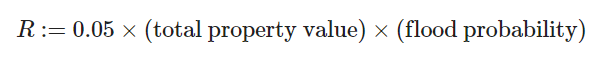

In [ ]:
labelled_data_R = pd.read_csv('resources/postcodes_labelled.csv')
labelled_data_R

In [ ]:
labelled_data_R.dtypes

In [ ]:
proba_risk_mapping = {
    '1': 0.001,
    '2': 0.002,
    '3': 0.003,
    '4': 0.005,
    '5': 0.01,
    '6': 0.015,
    '7': 0.02,
    '8': 0.03,
    '9': 0.04,
    '10': 0.05
}
proba_risk_mapping_int = {int(k): v for k, v in proba_risk_mapping.items()}

labelled_data_R['riskLabel'] = labelled_data_R['riskLabel'].map(proba_risk_mapping_int)



In [ ]:
labelled_data_R['R'] = 0.05*labelled_data_R['medianPrice']*labelled_data_R['riskLabel']

In [ ]:
labelled_data_R

In [ ]:
labelled_data_R = labelled_data_R.drop(columns = ['elevation','soilType', 'riskLabel'])

In [ ]:
labelled_data_R.dropna(subset=['R'], inplace=True)


In [ ]:
labelled_data_R

In [ ]:
latitude, longitude = ft.get_gps_lat_long_from_easting_northing(
    labelled_data_R['easting'].values, labelled_data_R['northing'].values, rads=False, dms=False
)

In [ ]:
labelled_data_R['latitude'] = latitude
labelled_data_R['longitude'] = longitude



In [ ]:
labelled_data_R = labelled_data_R.drop(columns = ['easting','northing','localAuthority'])

In [ ]:
labelled_data_R#.R.dtypes

# Now we're going to display our points with a colour that depends on R and varies from white to dark blue. We can choose the range of values we want to display for R, and the colour scale will adjust automatically. By clicking on the points, we obtain the characteristics 

In [ ]:
import folium
import ipywidgets as widgets
from IPython.display import display

def calculate_color(R, R_min, R_max):
    normalized_R = (R - R_min) / (R_max - R_min) if R_max > R_min else 0
    red = int((1 - normalized_R) * 255)
    green = int((1 - normalized_R) * 255)
    blue = 255
    return f'#{red:02x}{green:02x}{blue:02x}'

def update_map(R_min_filter, R_max_filter):
    m = folium.Map(location=[labelled_data_R["latitude"].mean(), labelled_data_R["longitude"].mean()], zoom_start=6)
    
    for idx, row in labelled_data_R.iterrows():
        if R_min_filter <= row['R'] <= R_max_filter:
            color = calculate_color(row['R'], R_min_filter, R_max_filter)
            popup_text = f"Postcode: {row['postcode']}, R-value: {row['R']}, medianPrice: {row['medianPrice']}, historicallyFlooded: {row['historicallyFlooded']}"
            folium.CircleMarker(
                location=(row["latitude"], row["longitude"]),
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                popup=folium.Popup(popup_text, parse_html=True)
            ).add_to(m)
    
    display(m)

R_min_widget = widgets.FloatSlider(value=labelled_data_R['R'].min(), min=labelled_data_R['R'].min(), max=labelled_data_R['R'].max(), description='R min:', continuous_update=False)
R_max_widget = widgets.FloatSlider(value=labelled_data_R['R'].max(), min=labelled_data_R['R'].min(), max=labelled_data_R['R'].max(), description='R max:', continuous_update=False)

ui = widgets.VBox([R_min_widget, R_max_widget])
out = widgets.interactive_output(update_map, {'R_min_filter': R_min_widget, 'R_max_filter': R_max_widget})

display(ui, out)

